# Setup

Imports

In [1]:
from sklearn.ensemble import RandomForestClassifier

## Define Useful Features

In [2]:
jtplot_style()

In [3]:
_is_even = lambda x: not x % 2

In [4]:
def find_bins(x, f=1):
    n = max(1, int(f * len(x)))
    if _is_even(n): n += 1
    if n > len(x): n -= 2
    
    return np.linspace(x.min(), x.max(), n)

In [5]:
def colorize(distr):
    def _colorize(x):
        if len(x.shape) == 1: x = np.expand_dims(x, 0)
        colors = np.array(['g'] * len(x))
        colors[distr(x)] = 'r'
        return colors.tolist() if len(colors) > 1 else colors[0]
    return _colorize

In [6]:
def to_rgb(x):
    rgb_dict = {'r': [255, 0, 0], 'g': [0, 255, 0], 'b': [0, 0, 255]}
    colors = np.zeros((x.shape[0], x.shape[1], 3), dtype=np.uint8)
    
    unique_colors = np.unique(x)
    if any(c not in rgb_dict.keys() for c in unique_colors):
        raise ValueError('some color keys are unspecified')
        
    for c in unique_colors:
        colors[x == c] = rgb_dict[c]
        
    return colors

In [7]:
def plot_background(cmap, n=100):
    xlim = plt.xlim()
    ylim = plt.ylim()
    xs = np.linspace(plt.xlim()[0], plt.xlim()[1], n)
    ys = np.linspace(plt.ylim()[0], plt.ylim()[1], n)
    
    xs, ys = np.meshgrid(xs, ys)
    xs = xs.reshape(-1); ys = ys.reshape(-1)
    
    colors = np.array(cmap(np.stack([xs, ys], 1))).reshape(n, n)
    if colors.dtype == np.float:
        colors = np.flipud(1 - colors)
        plt.imshow(colors, extent=(xlim[0], xlim[1], ylim[0], ylim[1]), alpha=0.1,
              interpolation='spline16', cmap='RdYlGn', vmin=0, vmax=1)
        return
    
    colors = to_rgb(np.flipud(colors))
    
    plt.imshow(colors, extent=(xlim[0], xlim[1], ylim[0], ylim[1]), alpha=0.1,
              interpolation='spline16')

In [8]:
cross_entropy = lambda input_, target: -(np.log(input_ + 1e-12) * target + np.log(1 - input_ + 1e-12) * (1 - target)).mean()

In [9]:
_distr_dict = {'lin': lambda x: x[:, 0] > x[:, 1],
              'cir': lambda x: x[:, 0] ** 2 + x[:, 1] ** 2 < 0.5 ** 2,
              'sin': lambda x: np.sin(x[:, 0]) + np.cos(x[:, 1]) > 1,
              'rnd': lambda x: np.random.binomial(1, 0.5, len(x)).astype(bool)}

In [10]:
def _spiral_distr(n=100, a=0, b=1, c=1):
    theta = np.linspace(0, 10 * np.pi, n)
    r = a + b * theta ** (1 / c)
    return r * np.stack([np.cos(theta), np.sin(theta)])

In [11]:
x = _spiral_distr(n=1000, a=0, b=0.04, c=1)
plot(x[0], x[1])

In [12]:
def _spiral(x, a=0, b=1, c=1, tol=0.01):
    r = np.linalg.norm(x, axis=-1)
    theta = np.arctan2(x[:, 1], x[:, 0])
    thetas = np.expand_dims(theta, -1) + np.expand_dims(np.arange(5), 0) * 2 * np.pi
    r_act = a + b * thetas ** (1 / c)
    errors = np.abs(r_act - np.expand_dims(r, -1))
    r_act = r_act[np.arange(len(r_act)), errors.argmin(-1)]
    return np.abs(r_act - r) < tol

## Load Data

In [13]:
num_pts = 1000
_real_distr = lambda x: _spiral(x, a=0, b=0.05, c=1, tol=0.08)
#_real_distr = _distr_dict['lin']
noise = 0
val_split = 0.2

In [14]:
def make_data(n, noise):
    x = np.random.rand(num_pts, 2) * 2 - 1
    y = _real_distr(x)
    _flip_ids = np.random.binomial(1, noise, num_pts).astype(bool)
    y[_flip_ids] = ~y[_flip_ids]
    return x, y
x, y = make_data(num_pts, noise)
x_val, y_val = make_data(int(num_pts * val_split), noise=0)
data_distr = lambda x: y_val

In [15]:
plt.scatter(x_val[:, 0], x_val[:, 1], marker='o', c=colorize(data_distr)(x_val))
plot_background(colorize(_real_distr))
plt.title(f'Cross Entropy: {cross_entropy(_real_distr(x_val), y_val):.2f}')
plt.show()

# Create Model

In [16]:
class Node:
    def __init__(self, x, y, generation=1, max_gen=np.inf, continous_frac=1):
        self._x = x
        self._y = y
        self._gen = generation
        
        self.val = y.mean() if len(y) > 1 else y[0]
        self.loss = cross_entropy(self.val.repeat(len(y)), y) if len(y) > 1 else 0
        
        self._fertile = lambda: hasattr(self, '_children')
        
        if generation < max_gen:
            try: self._split(max_gen, continous_frac)
            except: pass
            
    def _split(self, max_gen, continous_frac):
        self._find_split(continous_frac)
        
        ids = (self._x[:, self.feature] <= self.split_pt)
        if len(np.where(ids)[0]) in (0, len(self._x)): return
        self._children = (Node(self._x[ids], self._y[ids], self._gen + 1, max_gen, continous_frac),
                          Node(self._x[~ids], self._y[~ids], self._gen + 1, max_gen, continous_frac))
        
    def forward(self, x):
        if self._fertile():
            q = int(x[self.feature] > self.split_pt)
            return self._children[q].forward(x)
        else:
            return self.val
        
    def _print(self):
        print(' ' * (self._gen - 1), f"{self.feature}, {self.split_pt:.2f},"
                f"{self.val:.2f}, {self.loss:.2f}")
        if self._fertile():
            for c in self._children:
                c._print()
        
    def _find_split(self, continous_frac):
        x = self._x; y = self._y
        def _x_ent(idx):
            if len(idx) <= 1: return 0
            
            return cross_entropy(y[idx].mean().repeat(len(idx)), y[idx]) * len(idx)

        x_ents = []
        bins = []
        for feature in range(x.shape[-1]):
            x_ents.append([])
            bins.append(find_bins(x[:, feature], continous_frac))

            for b in bins[-1]:
                idx_lt = (x[:, feature] <= b)
                idx_gt = np.where(~idx_lt)[0]
                idx_lt = np.where(idx_lt)[0]

                x_ents[-1].append(_x_ent(idx_lt) + _x_ent(idx_gt))

        x_ents = np.array(x_ents)
        self.feature, split_pt = np.where(x_ents == x_ents.min())
        self.feature = self.feature[0]
        self.split_pt = bins[self.feature][split_pt[0]]

In [28]:
class Tree:
    def __init__(self, x, y, max_depth=None, continuous_frac=1):
        if max_depth is None: max_depth = np.inf
        if y.dtype != np.float: y = y.astype(float)
        self._root = Node(x, y, 1, max_depth, continuous_frac)
        
    def predict(self, x):
        y = np.zeros(len(x))
        for i in range(len(x)): y[i] = self._root.forward(x[i])
        return y
    
    def print(self):
        if not hasattr(self, '_root'): return
        
        print('feature, split_pt, val, loss')
        self._root._print()

# Train Model

In [18]:
def train_results(model, confidence=False, n=100):
    plt.scatter(x_val[:, 0], x_val[:, 1], marker='o', c=colorize(data_distr)(x_val))
    _model_color = model.predict if confidence else colorize(lambda x: model.predict(x) > 0.5)
    plot_background(_model_color, n)
    plt.title(f'Cross Entropy: {cross_entropy(model.predict(x_val), y_val):.2f}')
    plt.show()

In [19]:
model = Tree(x, y)

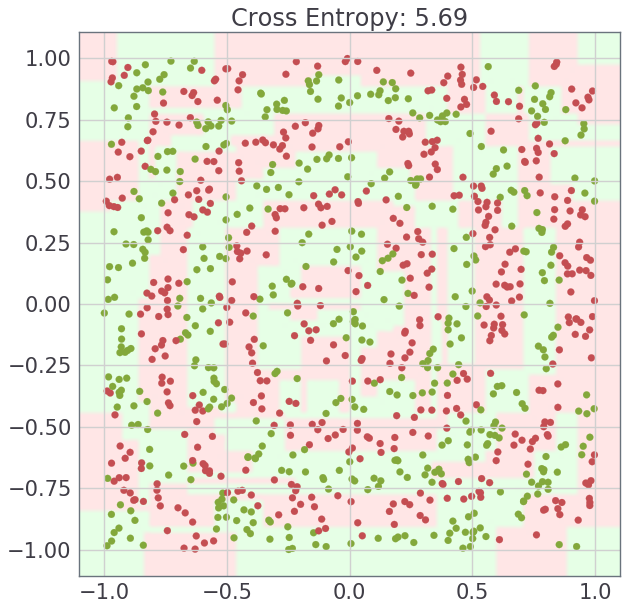

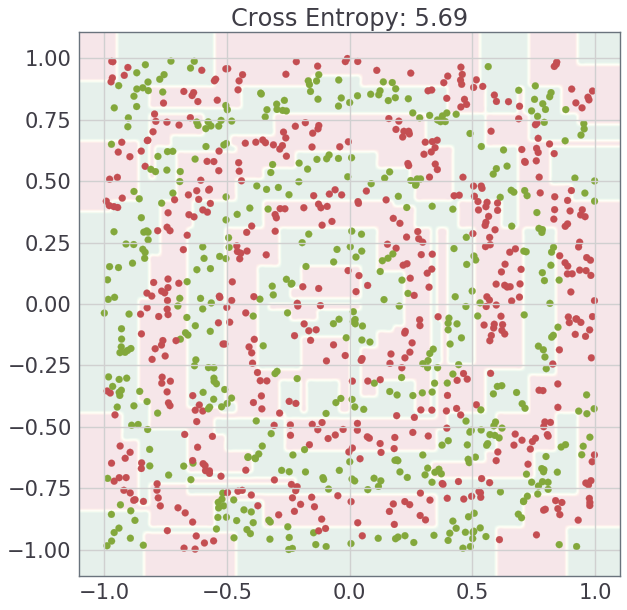

In [20]:
train_results(model, confidence=False)
train_results(model, confidence=True)

# Random Forests

In [21]:
model = RandomForestClassifier(10, n_jobs=-1)
model.fit(x, y.astype(float))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

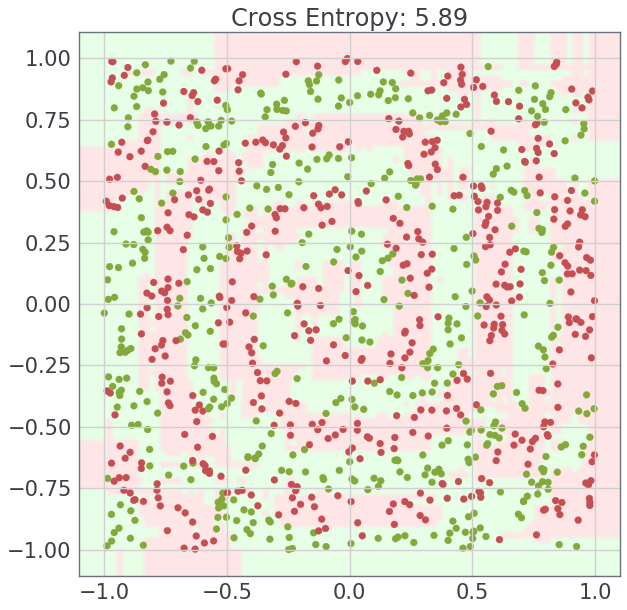

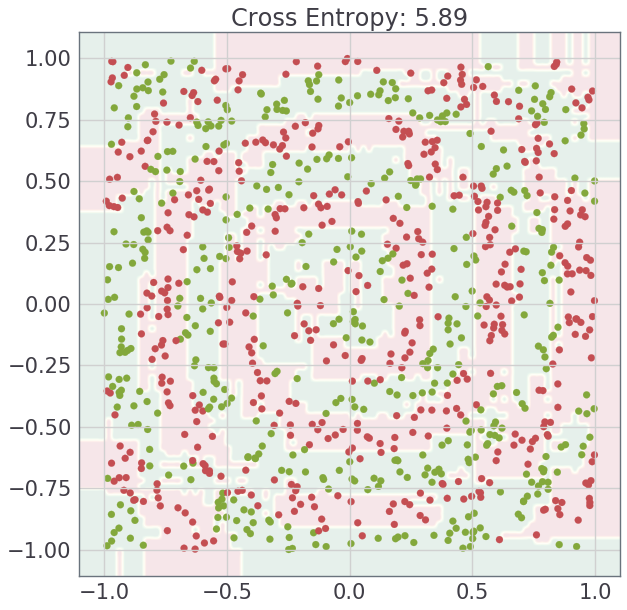

In [22]:
train_results(model, confidence=False)
train_results(model, confidence=True)